# Método de Quasi-Newton aplicado à função geofísica

Algoritmo de Quasi-Newton aplicado a um problema geofísico para estimar o raio e o topo de um prisma de base poligonal próximo de um cilindro.

# Importando pacotes

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from visual import histeq
from fatiando import utils
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.vis import myv
from fatiando.gridder import regular

# Funções para o prisma de base polygonal do fatiando

In [124]:
def pol2cart(l, M, L):
    '''
    This function transforms polar coordinates of the prisms
    into Cartesian coordinates and returns a list of polygonal
    prisms of the Fatiando a Terra.

    input

    l: list - each element is a list of [r, x0, y0, z1, z2, 'magnetization,
              whrere r is an array with the radial distances of the vertices,
              x0 and y0 are the origin cartesian coordinates of each prism,
              z1 and z2 are the top and bottom of each prism and
              magnetization is physical property
    M: int - number of vertices per prism
    L: int - number of prisms

    output

    mk: list - list of objects of the class
    fatiando.mesher.PolygonalPrism
    '''

    lk = []
    r = np.zeros(M)  # it contains radial distances of the vertices in polar coordinates
    verts = [] # it contains radial distances of the vertices in Cartesian coordinates

    assert len(l) == L, 'The size of m and the number of prisms must be equal'

    for lv in l:
        assert len(lv[0]) == M, 'All prisms must have M vertices'

    ang = 2*np.pi/M # angle between two vertices

    for lv in l:
        r = lv[0]
        verts=[]
        for i in range(M):
            verts.append([r[i]*np.cos(i*ang) + lv[1], r[i]*np.sin(i*ang) + lv[2]])
        lk.append(PolygonalPrism(verts, lv[3], lv[4], lv[5]))

    return lk

def param2polyprism(m, M, L, z0, dz, props):
    '''
    Returns a lis of objects of the class
    fatiando.mesher.PolygonalPrism

    input

    m: 1D array - parameter vector
    M: int - number of vertices
    L: int - number of prisms
    z0: float - top of the model
    dz: float - thickness of each prism
    props: dictionary - physical property

    output

    mv: list - list of fatiando.mesher.PolygonalPrism
    '''
    P = L*(M + 2)
    assert m.size == P, 'The size of m must be equal to L*(M + 2)'
    for i in range(P):
        assert m[i:i+M].all >= 0., 'The radial distances must be positives'

    r = np.zeros(M) # vector for radial distances
    mv = [] # list of prisms

    k = 0.
    for i in range(0, P, M + 2):
        r = m[i:M+i]
        mv.append([r, m[i+M], m[i+M+1], z0 + dz*k, z0 + dz*(k + 1.), props])
        k = k + 1.

    mv = pol2cart(mv, M, L)

    return mv

# Modelagem direta

In [125]:
M = 10 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters

z0_true = 100.    # depth of the top the shallowest prism
dz = 500.    # thickness of each prism

inc = -60.  # inclination
dec = 50.   # declination
intensity = 0.035 # intensity

props={'magnetization': utils.ang2vec(intensity, inc, dec)} # physical property: magnetization

r_true = 500.

r = np.zeros(M) + r_true # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, z0_true, z0_true + dz, props]]   # list of parameters of the prisms

# criando os prismas do fatiando
prisms = pol2cart(l, M, L)

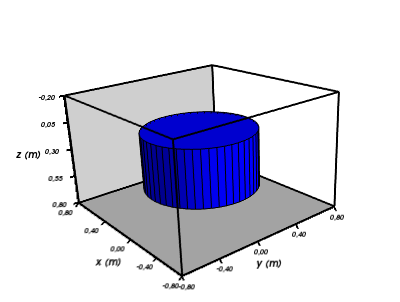

In [126]:
img(filename='bolacha.png')

# Pontos de observação

In [127]:
area = [-2000, 2000, -2000, 2000] #x minimum, x maximum, y minimum and y maximum
shape = (50,50) #number of data along the y and x directions
N = shape[0]*shape[1] #total number of data

#coordinates x and y of the data
xp, yp = regular(area, shape)

zp = np.zeros(N) - 100.

# Dados observados

In [128]:
data = polyprism.tf(xp, yp, zp, prisms, inc, dec) # predict data
amp_noise = 0.01*np.max(data)
data_noise = data + np.random.normal(loc=0., scale=amp_noise, size=shape[0]*shape[1]) # noise corrupted data

# Plot função desajuste

In [129]:
r_plot = np.linspace(10., 1000., 20)
z0_plot = np.linspace(-100., 500., 20)
r_plot,z0_plot = np.meshgrid(r_plot, z0_plot)
r_plot = r_plot.ravel()
z0_plot = z0_plot.ravel()
phi_plot = np.zeros_like(r_plot)

for i, (r, z) in enumerate(zip(r_plot,z0_plot)):
    m = np.zeros(M) + r
    m = np.hstack((m,np.zeros(2)))
    l = param2polyprism(m, M, L, z, dz, props)
    d_pred = polyprism.tf(xp, yp, zp, l, inc, dec)
    phi_plot[i] = np.sum((data - d_pred)**2)

r_plot = r_plot.reshape((20,20))
z0_plot = z0_plot.reshape((20,20))
phi_plot = phi_plot.reshape((20,20))

# equalizando as cores
phi_eq = histeq(phi_plot)
phi_eq = np.reshape(phi_eq,(20,20))
phi_eq = phi_eq

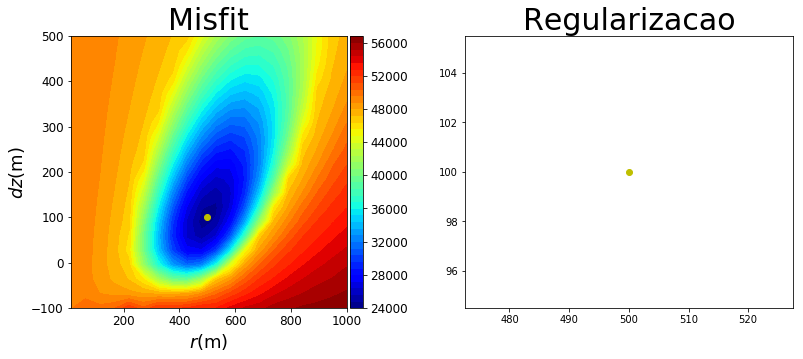

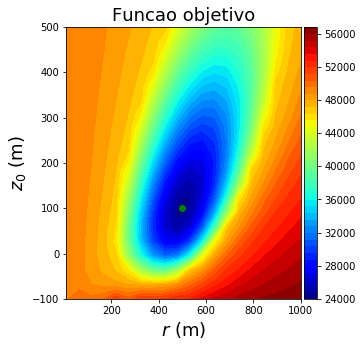

In [130]:
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'og')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

# Funções

In [131]:
def derivative_tf_z0(xp, yp, zp, prism, M, deltaz, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of one fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    delta: float - increment in x coordinate in meters
    inc: float - inclination
    dec: declination

    output

    df1: 1D array - derivative plus
    df2: 1D array - derivative minus
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - deltaa
    prism_plus[0].z1 += deltaz
    prism_minus[0].z1 -= deltaz

    df1 = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df2 = polyprism.tf(xp, yp, zp, prism_minus, inc, dec)

    return df1, df2

def derivative_tf_radiall(xp, yp, zp, prism, M, deltar, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of a fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in radial distance in meters
    inc: float - inclination
    dec: declination

    output

    df1: 1D array - derivative plus
    df2: 1D array - derivative minus
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    ang = 2.*np.pi/M # angle between two vertices
    
    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - delta

    for i in range(M):
        deltax = deltar*np.cos(i*ang)
        deltay = deltar*np.sin(i*ang)
        prism_plus[0].x[i] += deltax
        prism_plus[0].y[i] += deltay
        prism_minus[0].x[i] -= deltax
        prism_minus[0].y[i] -= deltay

    df1 = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df2 = polyprism.tf(xp, yp, zp, prism_minus, inc, dec)

    return df1, df2

def grad_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec, dobs):
    '''
    Returns the gradient vector for polygonal prisms using finite
    differences.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in meters for radial distance
    deltaz: float - increment in meters for depth
    inc: float - inclination of the local-geomagnetic field
    dec: float - declination of the local-geomagnetic field
    dobs: 1D array - data vector

    output

    grad: 1D array - gradient
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    drp, drm = derivative_tf_radiall(xp, yp, zp, prism[0], M, deltar, inc, dec)
    dzp, dzm = derivative_tf_z0(xp, yp, zp, prism[0], M, deltaz, inc, dec)
    grad = np.zeros(2)
    grad[0] = (np.sum((dobs - drp)*(dobs - drp)) - np.sum((dobs - drm)*(dobs - drm)))/(2.*deltar)
    grad[1] = (np.sum((dobs - dzp)*(dobs - dzp)) - np.sum((dobs - dzm)*(dobs - dzm)))/(2.*deltaz)
    
    return grad

# Funções de regularização

In [132]:
def regularization(p0, mi0, mi1, mit):
    '''
    Returns the value, gradient and Hessian of the constraint function.
    
    input
    
    p0: 1D array - parameters vector
    mi0: float - zero order Tikhonov's regularization parameter
    mi1: float - one order smoothness regularization parameter
    mit: float - total variation regularization parameter
    
    output
    
    phi: float - value of constraint function
    grad: 1D array - gradient of constraint funtion
    H: 2D array - Hessian of constraint function
    '''
    H = mi0*np.identity(p0.size)
    grad = mi0*p0
    phi = np.dot(p0, grad)
    
    RTR = np.array([[1.,-1.], [-1.,1.]])
    H += mi1*RTR
    grad += mi1*np.dot(RTR, p0)
    phi += np.dot(p0, grad)
    
    return phi, grad, H

# Função do vínculo de desigualdade

In [133]:
def desigualdade(p0, pmax, pmin, H):
    '''
    Returns the trasnformed parameters and the .
    
    input
    
    p0: 1D array - parameters vector
    pmax: 1D array - maximun parameters values
    pmin: 1D array - minimun parameters values
    H: 2D array - Hessian matrix
    
    output
    
    p0t: 1D array - transformed parameters
    HT: 2D array - transformed Hessian
    '''
    i_max = np.argwhere(p0 > pmax)
    i_min = np.argwhere(p0 < pmin)
    p0[i_max] = pmax[i_max] - 1e-8
    p0[i_min] = pmin[i_min] + 1e-8
    
    pt0 = - np.log((pmax - p0)/(p0 - pmin))
    
    T = ((pmax - p0)*(p0 - pmin))/(pmax - pmin)*np.identity(p0.size)
    
    HT = np.dot(H,T)
    
    return pt0, HT

In [134]:
def desigualdade_inv(pt, pmax, pmin):
    '''
    Returns the parameters vector.
    
    input
    
    p0: 1D array - parameters vector
    pmax: 1D array - maximun parameters values
    pmin: 1D array - minimun parameters values
    
    output
    
    p: 1D array - transformed parameters
    '''
  
    p = pmin + (pmax - pmin)/(1. + np.exp(-pt))
    
    i_max = np.argwhere(p0 > pmax)
    i_min = np.argwhere(p0 < pmin)
    p[i_max] = pmax[i_max] - 1e-8
    p[i_min] = pmin[i_min] + 1e-888
            
    return p

# Modelo interpretativo

In [181]:
# chute inicial
p01 = 700.
p02 = 300.

# incremento para as derivadas
deltar = 0.01*p01
deltaz = 0.01*p02

r = np.zeros(M) + p01 # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, p02, dz, props]]

prism0 = pol2cart(l, M, L)

d0 = polyprism.tf(xp, yp, zp, prism0, inc, dec)

# vetor do chute inicial
p0 = np.array([p01,p02])
H0 = np.identity(2)

# parâmetros para a strong Wolfe condition
c1 = 0.0001
beta = 0.4
c2 = 0.9

#critétio de parada
epsilon = 0.00001

# parâmetros de regularização
mi0 = 0.000001
mi1 = 0.
mit = 0.

# calculando o valor da função e do resíduo em p0
res0 = data_noise - d0
phi0 = np.sum(res0*res0)

# listas para armazenar as estimativas
p1_list = [p01]
p2_list = [p02]
phi_list = [phi0]

# iterações do algoritmo
itmax = 50
itmax_marq = 15

# valores de máximo e mínimo para a desigualdade
pmax = np.array([1000., 1000.])
pmin = np.array([10., 10.])

In [182]:
# calculando hessiana inversa do quasi-newton
def hessiana_qn(y, s, H0):
    '''
    Retorna a inversa da matriz Hessiana BFGS do método Quasi_Newton.

    input

    y: 1D array - diferença entre grad e grad0
    s: 1D array - deferença entre p - p0
    H0: 2D array - matriz Hessiana da iteração anterior

    output

    H: 2D array - matriz Hessiana
    '''
    assert y.shape == s.shape, 'y e s precisam ter o mesmo tamanho'
    
    y = y.reshape(2,1)
    s = s.reshape(2,1)
    
    yTs = np.dot(y.T, s)
    if abs(yTs) <= 1e-10:
        H = H0
    else:
        rho = 1/yTs
        syT = np.dot(s, y.T)
        ysT = np.dot(y, s.T)
        I = np.identity(2)
        IrhosyT = I - rho*syT
        IrhoysT = I - rho*ysT
        IrhosyTH0 = np.dot(IrhosyT, H0)
        H = np.dot(IrhosyTH0, IrhoysT) + rho*np.dot(s, s.T)
    
    return H

# Algoritmo Quasi-Newton

In [183]:
for i in range(itmax):
    m = 0.
    lamb = beta**m
    
    # calculando o gradiente
    grad0 = grad_geo(xp, yp, zp, prism0, M, deltar, deltaz, inc, dec, data_noise)
    
    # calculando p e atualizando para a próxima iteração
    deltap0 = - np.dot(H0, grad0)
    #print deltap0
    p = p0 + lamb*deltap0
    print p
    l = [[np.zeros(M) + p[0], x0, y0, p[1], dz, props]]
    prism = pol2cart(l, M, L)
    d = polyprism.tf(xp, yp, zp,prism, inc, dec)
    res = data_noise - d
    phi = np.sum(res*res)
    grad = grad_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec, data_noise)
    yps = grad - grad0
    s = p - p0
    
    # strong Wolfe condition
    while phi - phi0 > c1*lamb*np.sum(grad0*deltap0) and abs(np.sum(grad*deltap0)) > abs(c2*np.sum(grad0*deltap0)):
        m += 1.
        #print m
        lamb = beta**m
        p = p0 + lamb*deltap0
        print p
        l = [[np.zeros(M) + p[0], x0, y0, p[1], dz, props]]
        prism = pol2cart(l, M, L)
        d = polyprism.tf(xp, yp, zp, prism, inc, dec)
        res = data_noise - d
        phi = np.sum(res*res)
        grad = grad_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec, data_noise)
        yps = grad - grad0
        s = p - p0
        #print abs(phi - phi0)
        #print abs(c1*lamb*np.sum(grad0*deltap0))
        
    # printa os valores
    print 'iteração: %3d   lambda: %.2e   r: %3.2f   z_0: %3.2f   misfit: %.2e' % (i, lamb, p[0], p[1], phi)
    
    H = hessiana_qn(yps, s, H0)
    

    # armazenando a última estimativa
    phi_list.append(phi)
    p1_list.append(p[0])
    p2_list.append(p[1])
    
    if abs(phi - phi0)/phi0 <= epsilon:
        break
    else:
        # atualizando parâmetros
        p0 = p.copy()
        phi0 = phi
        prism0 = prism
        H0 = H.copy()

[ 700.15557484  286.49493502]
iteração:   0   lambda: 1.00e+00   r: 700.16   z_0: 286.49   misfit: 1.67e+03
[ 696.16568357   73.08772158]
[ 698.55961833  201.13204964]
iteração:   1   lambda: 4.00e-01   r: 698.56   z_0: 201.13   misfit: 8.89e+02
[ 690.77703887  152.2202103 ]
iteração:   2   lambda: 1.00e+00   r: 690.78   z_0: 152.22   misfit: 8.08e+02
[ 684.74011802  163.14352669]
iteração:   3   lambda: 1.00e+00   r: 684.74   z_0: 163.14   misfit: 7.37e+02
[ 655.46966553  165.49615324]
iteração:   4   lambda: 1.00e+00   r: 655.47   z_0: 165.50   misfit: 5.61e+02
[ 552.36937973  139.94456131]
iteração:   5   lambda: 1.00e+00   r: 552.37   z_0: 139.94   misfit: 2.04e+02
[ 514.23957267  111.93064379]
iteração:   6   lambda: 1.00e+00   r: 514.24   z_0: 111.93   misfit: 9.55e+01
[ 506.15536292   82.64100126]
iteração:   7   lambda: 1.00e+00   r: 506.16   z_0: 82.64   misfit: 3.32e+01
[ 516.21879968   86.60756603]
iteração:   8   lambda: 1.00e+00   r: 516.22   z_0: 86.61   misfit: 3.04e+01


In [184]:
print H0

[[ 14.79492786   5.77142732]
 [  5.77142732   7.77586808]]


# Plots de resultados

In [185]:
res_norm = (res - np.mean(res))/np.std(res)
res_plot = res.reshape(shape)
dpred = data.reshape(shape)
dobs = data_noise.reshape(shape)

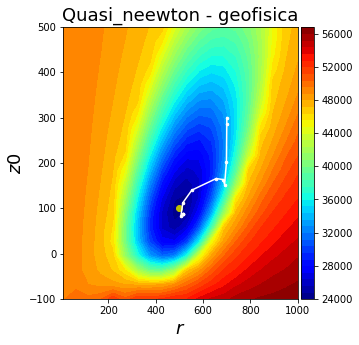

In [186]:
#plot
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'oy')
plt.plot(p1_list, p2_list, '.w-', markersize=5)
plt.title('Quasi_neewton - geofisica', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet')
plt.xlabel('$r$', fontsize=18)
plt.ylabel('$z0$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

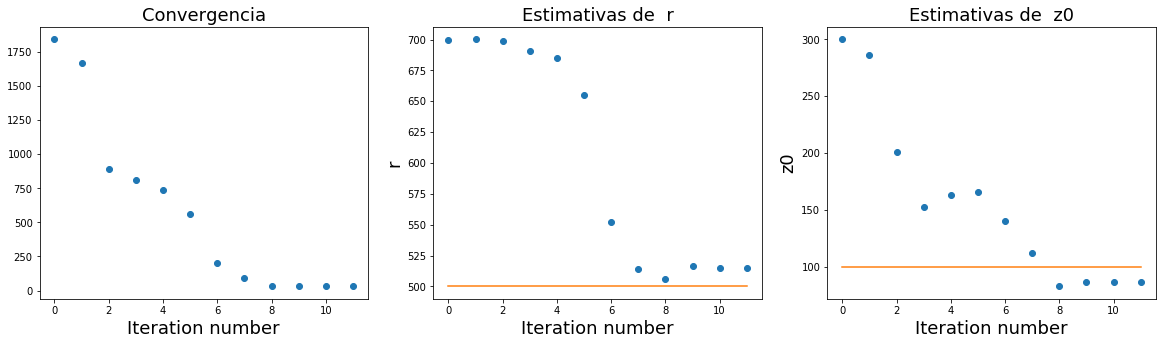

In [187]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Convergencia', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.plot(phi_list, 'o')

plt.subplot(1, 3, 2)
plt.title('Estimativas de  r', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.ylabel('r', fontsize = 18)
plt.plot(p1_list, 'o')
plt.plot(np.zeros(len(p1_list)) + r_true, '-')

plt.subplot(1, 3, 3)
plt.title('Estimativas de  z0', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.ylabel('z0', fontsize = 18)
plt.plot(p2_list, 'o')
plt.plot(np.zeros(len(p1_list)) + z0_true, '-')
plt.show()

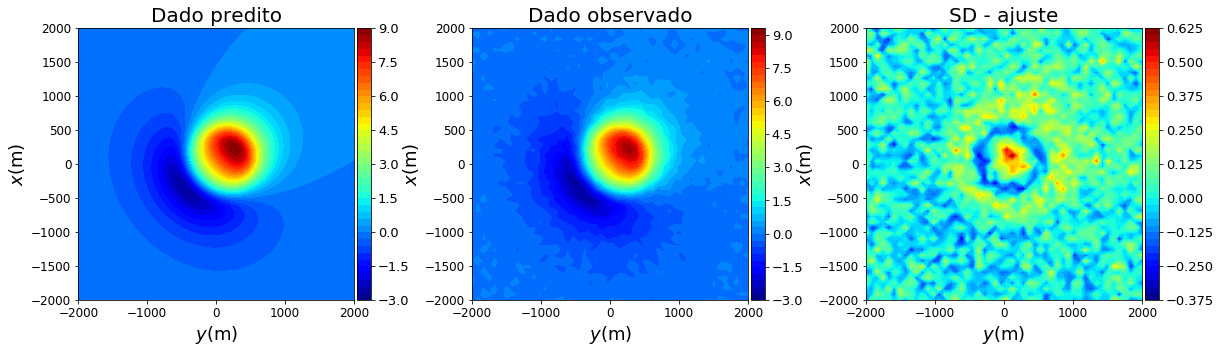

In [188]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dpred, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 3)
plt.title('SD - ajuste', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), res_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)
plt.show()

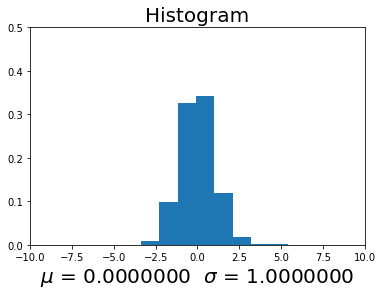

In [189]:
plt.plot(figsize=(30,25))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
plt.hist(res_norm,bins=nbins, normed=True)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.show()

In [190]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Misfit', fontsize=30)
plt.plot(500., 100., 'oy')
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$r$(m)', fontsize=18)
plt.ylabel('$dz$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).ax.tick_params(labelsize=12)

plt.subplot(1, 3, 2)
plt.title('Regularizacao', fontsize=30)
plt.plot(500., 100., 'oy')
plt.contourf(r_plot, z0_plot, phi_reg_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$r$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).ax.tick_params(labelsize=12)

plt.subplot(1, 3, 3)
plt.title('Funcao objetivo', fontsize=30)
plt.plot(500., 100., 'oy')
plt.contourf(r_plot, z0_plot, phi_eq+phi_reg_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$r$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=18)
plt.show()

NameError: name 'phi_reg_plot' is not defined